Mounted at /content/drive


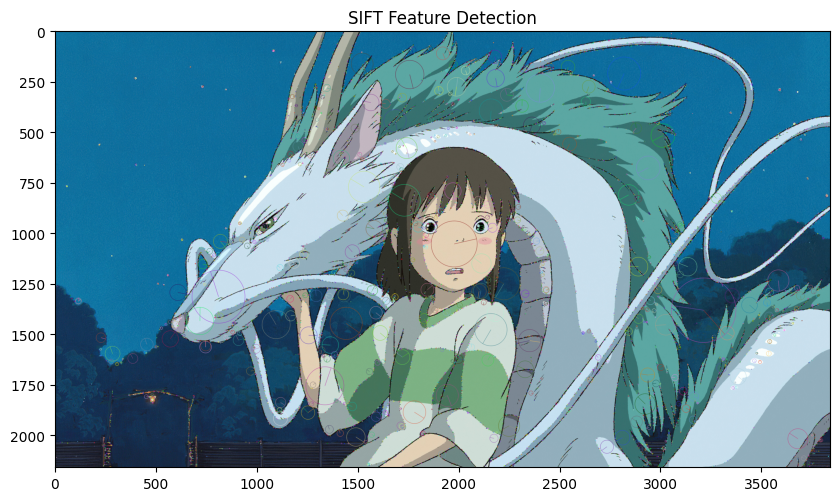

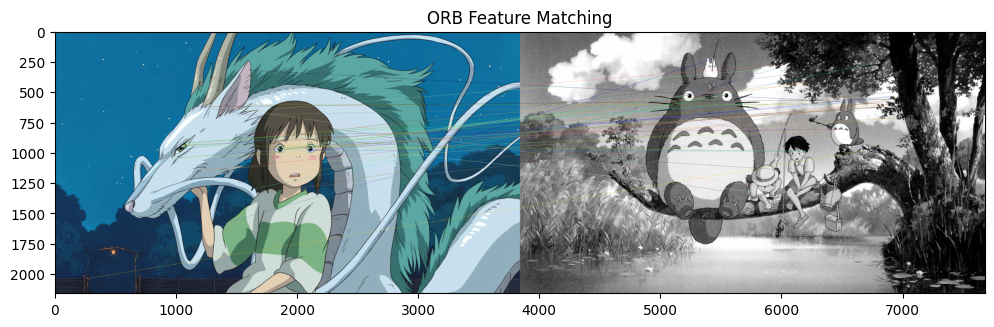

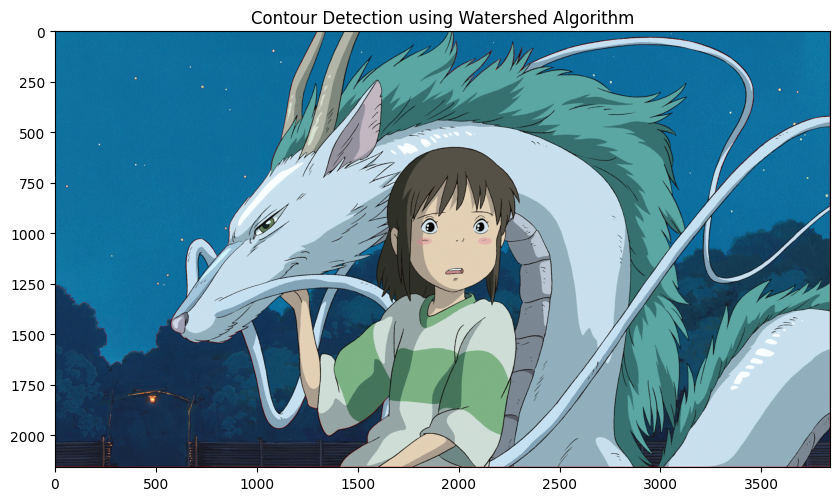

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

image_path = "/content/haku-spirited-away-3840x2160-18312.jpg"

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## 1️⃣ **SIFT Feature Detection**
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

sift_img = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display SIFT keypoints
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(sift_img, cv2.COLOR_BGR2RGB))
plt.title("SIFT Feature Detection")
plt.show()


## 2️⃣ **ORB Feature Matching using BFMatcher**
image2_path = "/content/my-neighbor-totoro-3840x2160-10733.jpg"
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Initialize ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(gray, None)
kp2, des2 = orb.detectAndCompute(image2, None)

# Use Brute Force Matcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw Matches
match_img = cv2.drawMatches(image, kp1, image2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display ORB Feature Matching
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title("ORB Feature Matching")
plt.show()


## 3️⃣ **Contour Detection using Watershed Algorithm**
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise using morphological operations
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Background and Foreground Extraction
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed Algorithm
image_copy = image.copy()
cv2.watershed(image_copy, markers)
image_copy[markers == -1] = [0, 0, 255]  # Mark boundaries in red

# Display Contour Detection Result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title("Contour Detection using Watershed Algorithm")
plt.show()


Epoch 1/10
469/469 - 156s - 332ms/step - loss: 0.1132 - val_loss: 0.1140
Epoch 2/10
469/469 - 149s - 317ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
469/469 - 149s - 319ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
469/469 - 153s - 327ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
469/469 - 198s - 423ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
469/469 - 149s - 317ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
469/469 - 206s - 440ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
469/469 - 202s - 431ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 - 203s - 432ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
469/469 - 201s - 428ms/step - loss: 0.1120 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


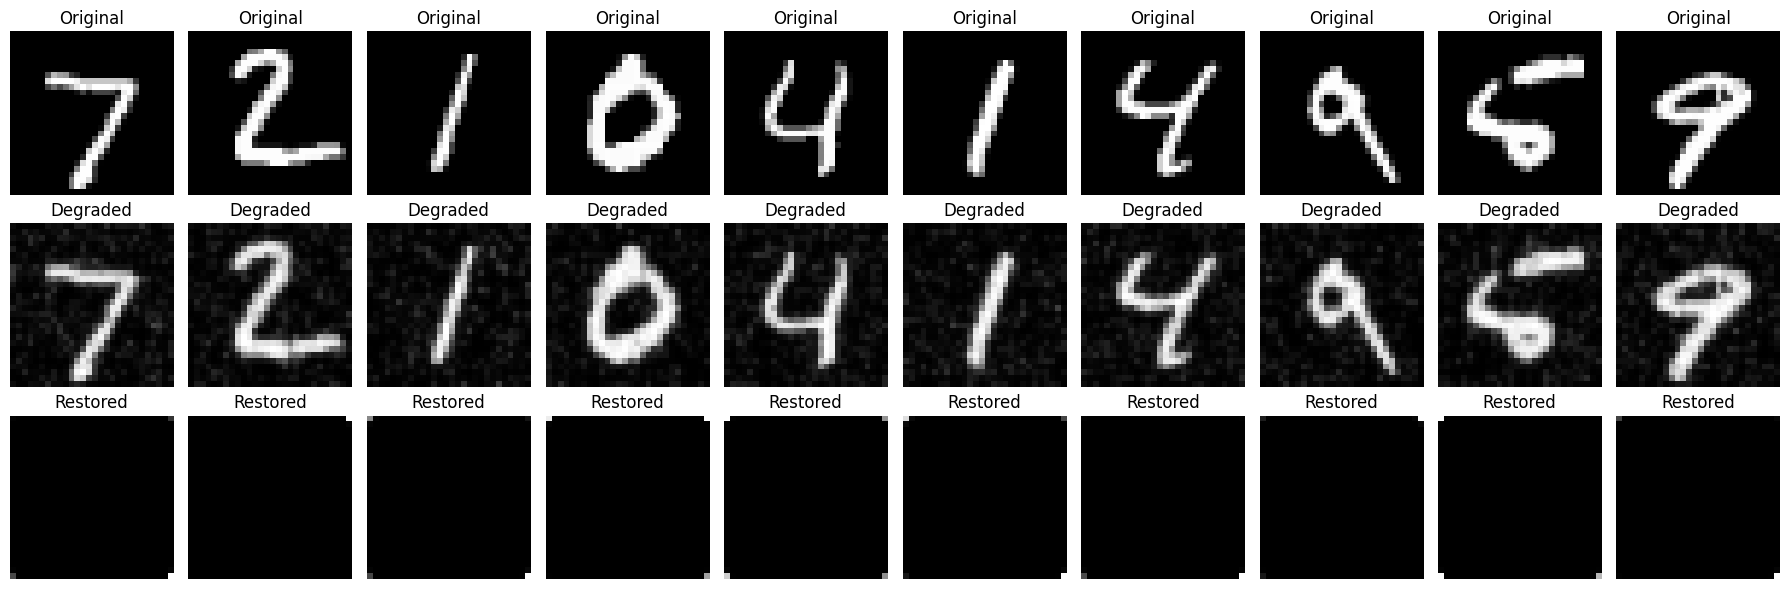

Average PSNR on 100 test images: 10.23 dB


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.util import random_noise
from skimage.filters import gaussian

# Step 1: Load & Preprocess MNIST Data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape for CNN (28x28x1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Step 2: Simulate Degradation (Noise + Blur)
def degrade_image(img):
    noisy = random_noise(img, mode='gaussian', var=0.01)
    blurred = gaussian(noisy, sigma=0.5, channel_axis=-1)
    return np.clip(blurred, 0., 1.)

x_train_noisy = np.array([degrade_image(img) for img in x_train])
x_test_noisy = np.array([degrade_image(img) for img in x_test])

# Step 3: Build the Autoencoder Model
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

# Step 4: Train the Autoencoder
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_noisy, x_test),
    verbose=2
)

# Step 5: Image Restoration & Evaluation
restored = autoencoder.predict(x_test_noisy)

# Function to display results
def show_images(original, degraded, restored, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Degraded
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(degraded[i].squeeze(), cmap="gray")
        plt.title("Degraded")
        plt.axis("off")

        # Restored
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(restored[i].squeeze(), cmap="gray")
        plt.title("Restored")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(x_test, x_test_noisy, restored)

# Optional: PSNR Evaluation
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

psnr_score = np.mean([psnr(x_test[i], restored[i]) for i in range(100)])
print(f"Average PSNR on 100 test images: {psnr_score:.2f} dB")
